In [76]:
import numpy as np
from astropy import coordinates as coord

In [469]:
data=np.load("att_oct_data.npz",allow_pickle=True)
[a for a in data.keys()]

['dt2',
 'sat_coords',
 'mag_calc',
 'mag_meas',
 'sun_meas',
 'angle',
 'sun_vec',
 'pout']

In [470]:
dt2=data['dt2']
sat_coords=data['sat_coords']

In [471]:
sat_mov=sat_coords[:,1:]-sat_coords[:,:-1]
sat_mov.shape

(3, 146)

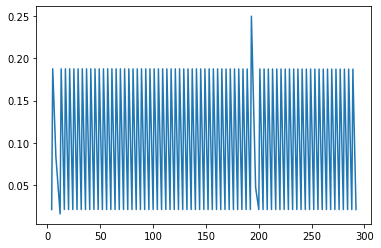

In [472]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot(dt2[1:-1],sat_mov[1][2:-1]/ddt[:-1])

In [473]:
pfinex4=data['pout']
#[3.46508217e+01, 2.61204706e+02, 8.52427661e+00, 2.31146590e+02, 9.85928507e-07, 7.56426794e+01, 2.17786890e+00, 5.52031335e-03,       5.27567832e-03]
def phi_fun(period,phi0,samp,sphase=90,accel=0):
    '''predict phase with some sinusoidal modulation (samp, sphase) and period gradient (accel)
    '''
    phi_max=phi0+360*(dt2/period+dt2**2*accel)
    phi_max-=360*(phi_max/360).astype(int)
    return phi_max+samp*np.sin(np.deg2rad(phi_max-sphase))

bangs=phi_fun(*pfinex4[:5])#[wsel]

In [474]:
mag_calc=data['mag_calc']
sun_vec=data['sun_vec']
mbody=data['mag_meas']

In [475]:
import satutils as su
sunvec_eci=np.array([su.fromangle(s.ra.value,s.dec.value) for s in sun_vec[1:-1]])
angle3=np.array([np.arccos(np.dot(mag_calc[i],sunvec_eci[i])) for i in range(len(dt2))])

In [476]:
#su.triad
i=10
eci_tr=su.triad(mag_calc[i],sunvec_eci[i])

In [477]:
satcoor2=[coord.EarthLocation.from_geodetic(r[0],r[1],r[2]*1e3) for r in sat_coords.T] 
#z_axis=[coord.SkyCoord(from_cart(),unit="deg",frame="altaz",location=satcoor2[i],obstime=times[i]) for i in [0,-1]]


In [478]:
dphi,dtheta=pfinex4[-2:]#0.05,0.05
modzaxis=[np.cos(dphi)*np.sin(dtheta),np.sin(dphi)*np.sin(dtheta),np.cos(dtheta)]
#zaxis
aliad=[su.triad(m,modzaxis) for m in mbody]
dphi*180/np.pi,dtheta*180/np.pi

(3.568967138854507, 18.730180612218952)

In [479]:
#angle2=data['angle']
eci_body=[]
for i in range(len(dt2)):
    eci_tr=su.triad(mag_calc[i],sunvec_eci[i])
    phi=np.deg2rad(bangs[i])
    awee=np.array([np.cos(angle2[i]),np.sin(angle2[i])*np.cos(phi),np.sin(angle2[i])*np.sin(phi)])# sun dir in EQ frame
    asun=aliad[i].T@awee
    body_tr=su.triad(mbody[i],asun)
    eci_body.append(eci_tr.T@body_tr)

In [480]:
eci_body=np.array(eci_body)

In [481]:
eci_norm=np.sqrt((eci_body[:,:,:]**2).sum(1))
eci_body=eci_body/eci_norm[:,np.newaxis,:]

In [482]:
eci_body[j,:,:]@[1,0,0]#mbody[j],mag_calc[j]

array([0.81250381, 0.32798178, 0.48193933])

In [483]:
eci_body[j,:,0]

array([0.81250381, 0.32798178, 0.48193933])

In [484]:
ex,ey,ez=eci_body[:,:,2].T  #coordinates of Z+ axis in equatorial CS

Text(0.5, 1.0, 'movement of Z+ axis components')

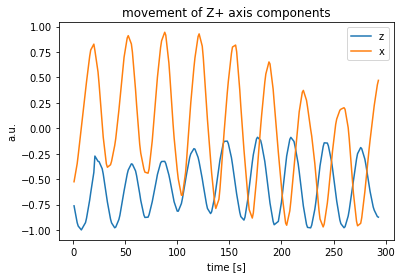

In [485]:
pl.plot(dt2,ez,label='z')
pl.plot(dt2,ex,label='x')
pl.legend()
pl.xlabel('time [s]')
pl.ylabel('a.u.')
pl.title("movement of Z+ axis components")

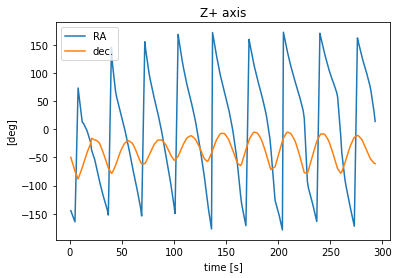

In [487]:
ra=np.arctan2(ey,ex)
fract=lambda a,b:a-(a/b).astype(int)*b
ra2=np.rad2deg(ra)
#ra2=fract(ra2+360,360)-360
er=np.sqrt(ex**2+ey**2)
dec=np.arctan2(ez,er)
pl.plot(dt2,ra2)
pl.plot(dt2,np.rad2deg(dec))
pl.ylabel('[deg]')
pl.xlabel('time [s]')
pl.title('Z+ axis')
pl.legend(["RA","dec."])

In [488]:
from astropy.time import Time
t0=Time("2021-10-17 04:20:03")

In [489]:
angdif_x=[np.arccos((eci_body[i,:,0]*eci_body[i-1,:,0]).sum()) for i in range(1,len(dt2))]
angdif_z=[np.arccos((eci_body[i,:,2]*eci_body[i-1,:,2]).sum()) for i in range(1,len(dt2))]

Text(0.5, 1.0, 'speed of axis movement')

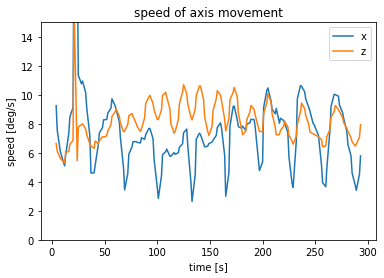

In [490]:
pl.plot(dt2[1:],np.rad2deg(angdif_x)/ddt)
pl.plot(dt2[1:],np.rad2deg(angdif_z)/ddt)
pl.ylim(0,15)
#pl.grid()
pl.legend(["x","z"])
pl.ylabel('speed [deg/s]')
pl.xlabel('time [s]')
pl.title('speed of axis movement')

In [491]:
axes_z=[]
axes_x=[]
sat_loc=[]
rep=sat_coords
for j in range(len(dt2)):
    loc=coord.EarthLocation.from_geodetic(rep[0][j]*u.deg,rep[1][j]*u.deg,rep[2][j]*u.km)
    at=t0+dt2[j]/24./60/60
    sat_loc.append(loc)
    axes_x.append(coord.SkyCoord(*eci_body[j,:,0],representation_type="cartesian", frame="fk5",unit='m',location=loc,obstime=at))
    axes_z.append(coord.SkyCoord(*eci_body[j,:,2],representation_type="cartesian", frame="fk5",unit='m',location=loc,obstime=at))

In [492]:
#dir2.transform_to(aaz).distance.au
magall=[]
for j in range(len(axes_z)):
    dir2=coord.SkyCoord(ra[j]*u.radian,dec[j]*u.radian)
    aa=coord.AltAz(location=axes_z[j].location,obstime=axes_z[j].obstime)
    magall.append(exalt(dir2.transform_to(aa)))
magall=np.array(magall).T

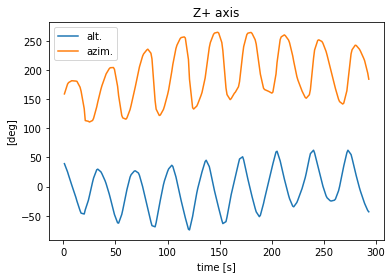

In [493]:
pl.plot(dt2,magall[0],label='alt.')
pl.plot(dt2,magall[1],label='azim.')
pl.ylabel('[deg]')
pl.xlabel('time [s]')
pl.title('Z+ axis')
pl.legend()

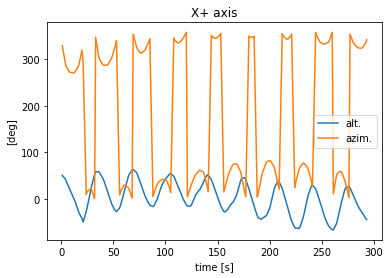

In [494]:
magxll=[]
for j in range(len(axes_z)):
    dir1=coord.SkyCoord(axes_x[j].icrs.ra,axes_x[j].icrs.dec)
    aa=coord.AltAz(location=axes_x[j].location,obstime=axes_x[j].obstime)
    magxll.append(exalt(dir1.transform_to(aa)))
magxll=np.array(magxll).T

magxll[1][magxll[1]>=360]=(magxll[1][magxll[1]>=360]-360)
pl.plot(dt2,magxll[0],label='alt.')
pl.plot(dt2,magxll[1],label='azim.')
pl.ylabel('[deg]')
pl.xlabel('time [s]')
pl.title('X+ axis')
pl.legend()

In [104]:
#!!!! not correct
azis=[d.altaz.az.value for d in axes_z]
alts=[d.altaz.alt.value for d in axes_z]

Text(0.5, 1.0, 'sat. movement')

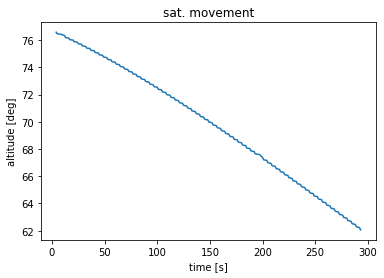

In [496]:
#sat_loc[j],sat_loc[j-1]
move=[]
dist=[]
for j in range(1,len(dt2)):
    dif=su.eloc2cart(sat_loc[j])-su.eloc2cart(sat_loc[j-1])
    dist.append(np.sqrt((np.array(dif)**2).sum()))
    move.append(coord.SkyCoord(*dif,representation_type="cartesian", frame="fk5",unit='m',location=sat_loc[j],obstime=axes_x[j].obstime).altaz)
pl.plot(dt2[1:],[m.alt.value for m in move])
pl.ylabel('altitude [deg]')
pl.xlabel('time [s]')
pl.title('sat. movement')

Text(0.5, 1.0, 'sat. movement')

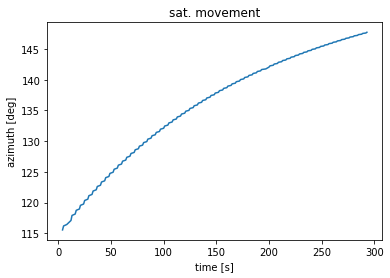

In [498]:
pl.plot(dt2[1:],[m.az.value for m in move])
#pl.plot(dt2,azis)
pl.ylabel('azimuth [deg]')
pl.xlabel('time [s]')
pl.title('sat. movement')
#pl.xlim(10,30)
#pl.ylim(177,180)

### testing the AstroPy algorithms

In [296]:
lob=coord.EarthLocation.from_geodetic(20*u.deg,0*u.deg,10*u.m)
from astropy import units as u
loc=coord.EarthLocation.from_geodetic(0*u.deg,30*u.deg,(6378+10)*u.m)
dir1=coord.SkyCoord(0,0.0,-1,representation_type="cartesian", frame="fk5",unit='m',location=loc,obstime=t0)
dir1.icrs.dec.deg,dir1.altaz.az.deg

(-89.99999392167888, 87.50969339719123)

In [322]:
loc=coord.EarthLocation.from_geodetic(20*u.deg,10*u.deg,100*u.km)
loc2=coord.EarthLocation.from_geodetic(0*u.deg,30*u.deg,height=10*u.m)
np.sqrt(loc.x.value**2+loc.y.value**2+loc.z.value**2)
#loc.norm()

In [327]:
obj = coord.EarthLocation(-1*u.deg, 52*u.deg, height=10.*u.km)
home = coord.EarthLocation(-1*u.deg, 52*u.deg, height=0.*u.km)

def ap_dist(obj,home,t=None):
    if t==None: t = Time('J2010')
    itrs_vec = obj.get_itrs(t).cartesian - home.get_itrs(t).cartesian
    cirs_vec = coord.ITRS(itrs_vec, obstime=t).transform_to(coord.CIRS(obstime=t)).cartesian
    cirs_topo = coord.CIRS(cirs_vec, obstime=t, location=home)
    return cirs_topo.transform_to(coord.AltAz(obstime=t, location=home))

moo=ap_dist(sat_loc[10],sat_loc[9])

<AltAz Coordinate (obstime=J2010.000, location=(1209.26163353, -2809.93188424, -6207.90131746) km, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt, distance) in (deg, deg, km)
    (198.90981322, 0.08673591, 7.65715963)>

In [350]:
exalt=lambda moo:[moo.alt.value,moo.az.value]
disall=[ap_dist(sat_loc[i],sat_loc[i-1]) for i in range(1,len(sat_loc))]
#moo.alt,moo.az

In [354]:
dists2=np.array([d.cartesian.norm().value for d in disall])

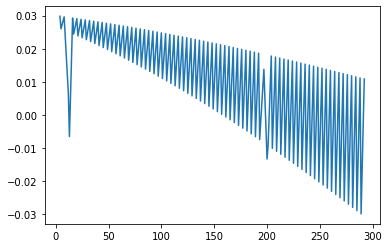

In [369]:
mall=np.array([exalt(m) for m in disall])
pl.plot(dt2[1:-1],mall[:-1,0]/ddt[:-1])
#pl.plot(dists2[1:]/ddt[:-1])
#pl.ylim(5,10)

from datetime import datetime,timedelta
coord.get_constellation(coord.get_body('jupiter',time=Time(datetime.now()-timedelta(100))))
#coord.get_body?

In [289]:
pts=coord.SphericalRepresentation(rep[0]*u.deg,rep[1]*u.deg,(rep[2])*u.km)
ip=pts[2]#.separation_3d(pts[1])
dis=ip.to_cartesian()-pts[3].to_cartesian()
dis.norm()

<Quantity 7.6477124 km>

Text(0, 0.5, 'satellite velocity [km/s]')

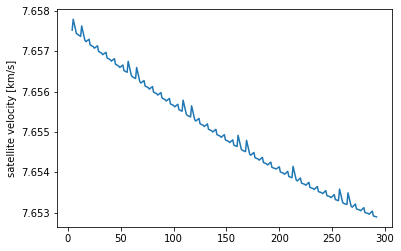

In [155]:
ddt=dt2[1:]-dt2[:-1]
pl.plot(dt2[1:-1],np.array(dist[1:])/1e3/ddt[:-1])
pl.ylabel("satellite velocity [km/s]")

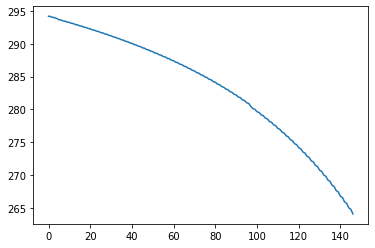

In [202]:
pl.plot(sat_coords[0])

In [501]:
import pytz
tz=pytz.timezone("UTC")
import predict
qth=[0,0,0]
tle= """GRBALPHA                
1 47959U 21022AD  21290.51353261  .00001924  00000-0  13588-3 0  9995
2 47959  97.5461 190.1749 0020093 254.7882 105.1103 15.05955928 30248"""
#1 47959U 21022AD  21193.19189613  .00000206  00000-0  18448-4 0  9992
#2 47959  97.5583  94.8656 0020163 224.9247 288.7034 15.05738947 15594

rep=[]
stmp0=tz.localize((t0-0.1).to_datetime()).timestamp()
for dmp in range(0,10000,100):
    y=predict.observe(tle, qth, at=stmp0+dmp)
    rep.append([y['longitude'],y['latitude'],y['altitude']])
rep=np.array(rep).T

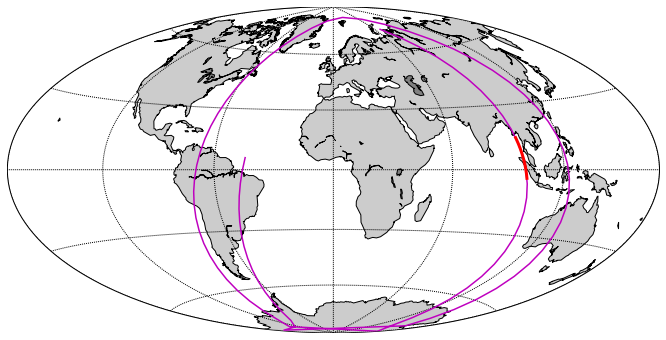

In [502]:
path=sat_coords.T
from mpl_toolkits.basemap import Basemap
pl.figure(figsize=(12,6))
m = Basemap(projection='hammer',lon_0=0,resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,420.,60.))

ok=m.fillcontinents(color='0.8',lake_color='0.5')
x,y=m(rep[0],rep[1])
m.plot(x,y,'-m')
x,y=m(path[:,0],path[:,1])
m.plot(x,y,'r',linewidth=3)


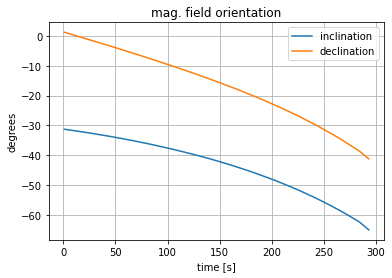

In [456]:
def cart2ang(ex,ey,ez):
    ra=np.arctan2(ey,ex)
    fract=lambda a,b:a-(a/b).astype(int)*b
    ra2=np.rad2deg(ra)
    ra2=fract(ra2+360,360)-360
    er=np.sqrt(ex**2+ey**2)
    dec=np.arctan2(ez,er)
    return ra2,np.rad2deg(dec)

mag_altaz=cart2ang(*mag_calc.T)
pl.plot(dt2,mag_altaz[0],label="inclination")
pl.plot(dt2,mag_altaz[1],label="declination")
pl.legend()
pl.ylabel("degrees")
pl.xlabel("time [s]")
pl.title("mag. field orientation")
pl.grid()

In [459]:
(t0+8/24./60).to_datetime().timestamp()-stmp0

9120.0

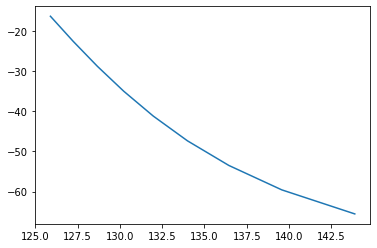

In [457]:
pl.plot(rep[0][91:140],rep[1][91:140])

In [452]:
rep[0][86],rep[1][86],rep[0][3+86],rep[1][3+86]

(295.78872196474407, -60.3017470824006, 271.50318805257706, -77.46659654411859)

In [468]:
t0

<Time object: scale='utc' format='iso' value=2021-10-17 04:20:03.000>

In [467]:
import pytz
predict.observe(tle, qth, at=datetime(2022,10,17,4,20,11,tzinfo=pytz.utc).timestamp())

{'norad_id': 47959,
 'name': 'GRBALPHA                ',
 'epoch': 1665980411.0,
 'latitude': -19.19202247522986,
 'longitude': 99.3897073068119,
 'azimuth': 109.3224774916989,
 'elevation': -47.39313924134331,
 'orbital_velocity': 27286.278452178794,
 'footprint': 5145.580390271702,
 'altitude': 556.5684029101985,
 'slant_range': 10117.987396247165,
 'eclipse_depth': -98.16021712845888,
 'orbital_phase': 176.95885716437218,
 'orbital_model': 'SGP4',
 'visibility': b'D',
 'sunlit': 1,
 'orbit': 8534,
 'geostationary': 0,
 'has_aos': 1,
 'decayed': 0,
 'doppler': 238.4285877025284,
 'eci_x': -6450.027320542173,
 'eci_y': -1148.4335040341082,
 'eci_z': -2266.3989806539957,
 'eci_vx': -2.5822153088061808,
 'eci_vy': 0.6094766064150267,
 'eci_vz': 7.099989645395567,
 'eci_sun_x': -136438611.487549,
 'eci_sun_y': -55176128.441468425,
 'eci_sun_z': -23920472.828057557,
 'eci_obs_x': -78.59649218775412,
 'eci_obs_y': 6377.652717276535,
 'eci_obs_z': 0.0,
 'beta_angle': -12.987281875595015}